# Import Libraries

In [2]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm

tqdm.pandas()

# Import Dataset

In [5]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTaHQtEVdX4aa-ltblBnHQItdlH3t-C13cn05KtY2vEoIWfaqfYF_Ul6iCN2v0XysoJooL45caKzQ8E/pub?output=csv')
df.head()

,id,token,entity
0,D0001,Pelaku,NaN
1,D0001,pembunuhan,CRIMETYPE
2,D0001,dan,LAW
3,D0001,pemerkosaan,CRIMETYPE
4,D0001,AA,PER


# Utility Functions

In [6]:
def wordcloud(df, column):
  text = df[column].str.cat(sep=' ')
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  
  plt.figure(figsize=(8, 4))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

# Preprocessing For Model

## Casefolding

In [7]:
df['lower'] = df['token'].str.lower()
df.head()

,id,token,entity,lower
0,D0001,Pelaku,NaN,pelaku
1,D0001,pembunuhan,CRIMETYPE,pembunuhan
2,D0001,dan,LAW,dan
3,D0001,pemerkosaan,CRIMETYPE,pemerkosaan
4,D0001,AA,PER,aa


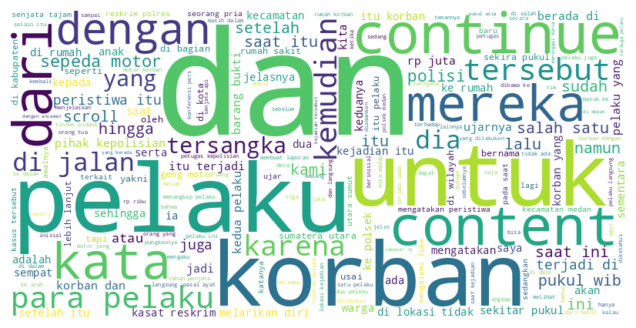

In [5]:
wordcloud(df, 'lower')

## Remove Punctuation and Special Characters

In [8]:
def get_alphanumeric(text):
    if pd.isna(text):
        return ''
    text = str(text)
    for word in ['scroll', 'to', 'continue', 'with', 'content']:
        text = text.replace(word, '')
    return re.sub('[^0-9a-zA-Z -]+', '', text)

df['alnum'] = df['lower'].apply(get_alphanumeric)
df.head()

,id,token,entity,lower,alnum
0,D0001,Pelaku,NaN,pelaku,pelaku
1,D0001,pembunuhan,CRIMETYPE,pembunuhan,pembunuhan
2,D0001,dan,LAW,dan,dan
3,D0001,pemerkosaan,CRIMETYPE,pemerkosaan,pemerkosaan
4,D0001,AA,PER,aa,aa


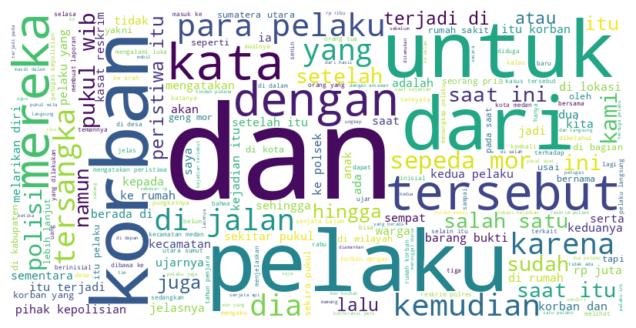

In [9]:
wordcloud(df, 'alnum')

## Remove Stopwords

In [10]:
stopwords_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQSgOspA2PfHRdIteS1IE7C3pBRiA2Udl-iIvRjZRhdTkuJa7BGpajHrDXRit2cLkZNM3_XSanKahQx/pub?output=csv'
stopwords = pd.read_csv(stopwords_url)['stopword'].to_list()
stopwords[:10]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir']

In [11]:
def remove_stopwords(text: str):
  return ' '.join([word for word in text.split() if word not in stopwords])

df['no_stopwords'] = df['alnum'].apply(remove_stopwords)
df.head()

,id,token,entity,lower,alnum,no_stopwords
0,D0001,Pelaku,NaN,pelaku,pelaku,pelaku
1,D0001,pembunuhan,CRIMETYPE,pembunuhan,pembunuhan,pembunuhan
2,D0001,dan,LAW,dan,dan,
3,D0001,pemerkosaan,CRIMETYPE,pemerkosaan,pemerkosaan,pemerkosaan
4,D0001,AA,PER,aa,aa,aa


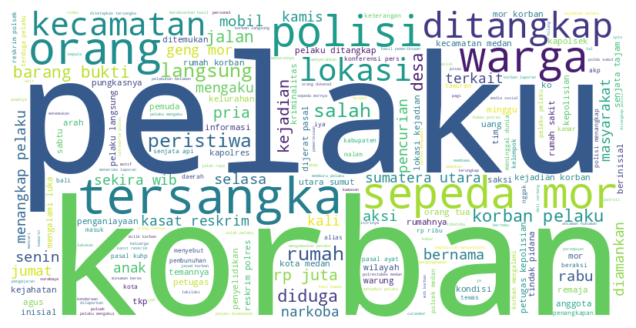

In [12]:
wordcloud(df, 'no_stopwords')

## Stemming

In [13]:
%pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.9 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text: str):
  return ' '.join([stemmer.stem(word) for word in text.split()])

df['stemmed'] = df['no_stopwords'].progress_apply(stem_text)
df.head()

100%|██████████| 198225/198225 [10:33<00:00, 312.88it/s] 


,id,token,entity,lower,alnum,no_stopwords,stemmed
0,D0001,Pelaku,O,pelaku,pelaku,pelaku,laku
1,D0001,pembunuhan,CRIMETYPE,pembunuhan,pembunuhan,pembunuhan,bunuh
2,D0001,dan,O,dan,dan,,
3,D0001,pemerkosaan,CRIMETYPE,pemerkosaan,pemerkosaan,pemerkosaan,perkosa
4,D0001,AA,PER,aa,aa,aa,aa


In [ ]:
df.to_csv('../data/processed/stemmed.csv', index=False)

## Remove Null Values

In [3]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSaby9idXEvKCzIhvQ3UwKGpYckAvmgyHVF_6anpLkUqZrKAQzJC9c_nSy6SSSP3EFQEBii3K3qeAaw/pub?output=csv')
df.dropna(subset=['stemmed'], inplace=True)
df.isnull().sum()

id                  0
token               0
entity          87013
lower               0
alnum               0
no_stopwords        0
stemmed             0
dtype: int64

In [ ]:
df.to_csv('/kaggle/input/stemed/stemmed1.csv', index=False)

# Training 1

In [4]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT8sMazFJAfWr56T6IW4w2l7LJpfNw2GljmCYapU-TWtPShnf6YLrWlhd0BkwYrLqIoh-VhVF5YZd8o/pub?output=csv')
df.head()

/tmp/ipykernel_107/2954492507.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT8sMazFJAfWr56T6IW4w2l7LJpfNw2GljmCYapU-TWtPShnf6YLrWlhd0BkwYrLqIoh-VhVF5YZd8o/pub?output=csv')


,id,token,entity,stemmed
0,D0001,Pelaku,O,laku
1,D0001,pembunuhan,CRIMETYPE,bunuh
2,D0001,dan,O,NaN
3,D0001,pemerkosaan,CRIMETYPE,perkosa
4,D0001,AA,PER,aa


## Split Data

In [5]:
df['entity'] = df['entity'].fillna('')
df.head()

,id,token,entity,stemmed
0,D0001,Pelaku,O,laku
1,D0001,pembunuhan,CRIMETYPE,bunuh
2,D0001,dan,O,NaN
3,D0001,pemerkosaan,CRIMETYPE,perkosa
4,D0001,AA,PER,aa


In [6]:
print("Checking entity column values:")
print(df['entity'].value_counts(dropna=False))
print(f"\nData type: {df['entity'].dtype}")
print(f"Sample values: {df['entity'].head(10).tolist()}")

Checking entity column values:
entity
             197226
O               773
EVIDENCE         58
LAW              50
PER              27
LOC              27
CRIMETYPE        19
GPE              15
DAT              14
NOR              13
ORG               3
Name: count, dtype: int64

Data type: object
Sample values: ['O', 'CRIMETYPE', 'O', 'CRIMETYPE', 'PER', 'O', 'O', 'O', 'O', 'O']


In [7]:
def create_manual_entity_mapping():
    entity_mapping = {
        '': 0,          # Empty
        'O': 0,         # Outside entity (default)
        'PER': 1,       # Person
        'LOC': 2,       # Location  
        'GPE': 3,       # Geopolitical entity
        'NOR': 4,       # Organization
        'LAW': 5,       # Law
        'DAT': 6,       # Date
        'CRIMETYPE': 7, # Crime type
        'EVIDENCE': 8   # Evidence
    }
    return entity_mapping

entity_mapping = create_manual_entity_mapping()

def encode_entity_manual(entity):
    """Encode entity menggunakan mapping manual"""
    if pd.isna(entity):
        return 0
    entity_str = str(entity).strip()
    return entity_mapping.get(entity_str, 0)  # Default ke 0 jika tidak ditemukan

df['entity_manual'] = df['entity'].apply(encode_entity_manual)

print("Manual encoding results:")
manual_counts = df[['entity', 'entity_manual']].value_counts()
print(manual_counts)

Manual encoding results:
entity     entity_manual
           0                197226
O          0                   773
EVIDENCE   8                    58
LAW        5                    50
LOC        2                    27
PER        1                    27
CRIMETYPE  7                    19
GPE        3                    15
DAT        6                    14
NOR        4                    13
ORG        0                     3
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split

texts = df['stemmed'].iloc[:1000].to_list()
labels = df['entity_manual'].iloc[:1000].to_list()

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

print("Training data prepared successfully!")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Unique labels: {sorted(set(y_train + y_test))}")

Training data prepared successfully!
Training samples: 800
Test samples: 200
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8]
